## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on simulated P1D data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.archive import gadget_archive
from lace.archive import nyx_archive
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import data_gadget
from cup1d.data import data_nyx
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label="growth"
if type(test_sim_label)==int:
    drop_sim=str(test_sim_label)
    print('will drop sim number {} from emulator'.format(drop_sim))
else:
    drop_sim=None

In [3]:
# add high-k measurement (will change emulator settings as well)
add_hires=False
if add_hires:
    kmax_Mpc=8
    polyfit_ndeg=7
else:
    kmax_Mpc=4
    polyfit_ndeg=5
    extra_data=None

In [4]:
# specify simulation suite and P1D mesurements
z_max=4.5
data_label='Chabanier2019'
use_nyx=False
if use_nyx:
    if drop_sim:
        drop_sim="nyx_"+drop_sim
    archive=nyx_archive.NyxArchive(verbose=True)
    data=data_nyx.Nyx_P1D(archive=archive,sim_label="nyx_"+str(test_sim_label),
                                z_max=z_max,data_cov_label=data_label,
                                polyfit_kmax_Mpc=kmax_Mpc,
                                polyfit_ndeg=polyfit_ndeg)
    # option to add extra P1D (high-resolution)
    if add_hires:
        extra_data=data_nyx.Nyx_P1D(archive=archive,
                                sim_label="nyx_"+str(test_sim_label),
                                z_max=z_max,
                                polyfit_kmax_Mpc=kmax_Mpc,
                                polyfit_ndeg=polyfit_ndeg,
                                data_cov_label='Karacayli2022')
else:
    if drop_sim:
        drop_sim="mpg_"+drop_sim
    archive=gadget_archive.GadgetArchive(postproc='Cabayol23')
    data=data_gadget.Gadget_P1D(archive=archive,sim_label="mpg_"+str(test_sim_label),
                                z_max=z_max,data_cov_label=data_label,
                                polyfit_kmax_Mpc=kmax_Mpc,
                                polyfit_ndeg=polyfit_ndeg)
    # option to add extra P1D (high-resolution)
    if add_hires:
        extra_data=data_gadget.Gadget_P1D(archive=archive,
                                sim_label="mpg_"+str(test_sim_label),
                                z_max=z_max,
                                polyfit_kmax_Mpc=kmax_Mpc,
                                polyfit_ndeg=polyfit_ndeg,
                                data_cov_label='Karacayli2022')

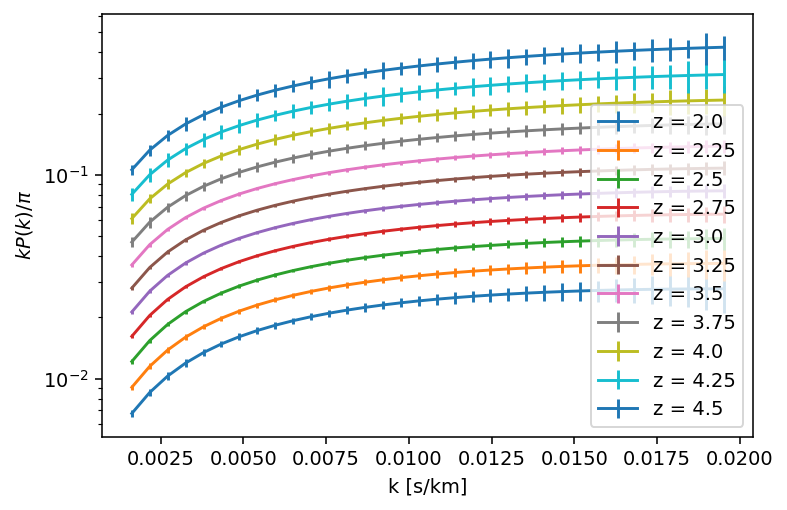

In [5]:
data.plot_p1d()

In [6]:
if extra_data:
    extra_data.plot_p1d()

### Emulator and training set

Create a set of training data to train an emulator

In [7]:
if use_nyx:
    emu_params=["Delta2_p", "n_p", "mF", "sigT_Mpc", "gamma", "lambda_P"]
else:
    emu_params=["Delta2_p", "n_p", "mF", "sigT_Mpc", "gamma", "kF_Mpc"]

In [8]:
use_gp=False
if use_gp:
    if use_nyx:
        raise ValueError('can not use GP with Nyx emulator')
    emulator=gp_emulator.GPEmulator(archive=archive,emu_params=emu_params,
                                    drop_sim=drop_sim,kmax_Mpc=kmax_Mpc,ndeg=polyfit_ndeg)
else:
    emulator=nn_emulator.NNEmulator(archive=archive,emu_params=emu_params,
                                    drop_sim=drop_sim,kmax_Mpc=kmax_Mpc,ndeg=polyfit_ndeg)

Selected custom emulator
Use custom archive provided by the user
Training samples in archive : 9900


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [9]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=2
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

In [10]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data,emulator=emulator,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor,
                            extra_p1d_data=extra_data)

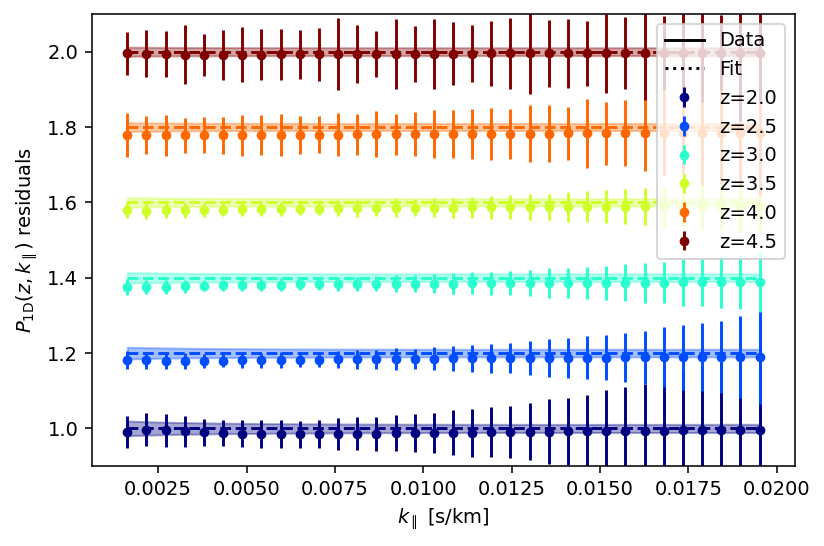

In [11]:
like.plot_p1d(residuals=True,plot_every_iz=2)

In [12]:
if extra_data:
    like.extra_p1d_like.plot_p1d(residuals=True,plot_every_iz=2)

# Try iminuit minimizer

In [13]:
test_values=len(free_param_names)*[0.5]
ini_chi2=like.get_chi2(values=test_values)
print('chi2 =',ini_chi2)

chi2 = 49.519597177841895


In [14]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

In [15]:
minimizer.minimize(compute_hesse=True)

In [16]:
best_fit_values=np.array(minimizer.minimizer.values)
best_chi2=like.get_chi2(values=best_fit_values)
print('chi2 improved from {} to {}'.format(ini_chi2,best_chi2))

chi2 improved from 49.519597177841895 to 0.47892182693599095


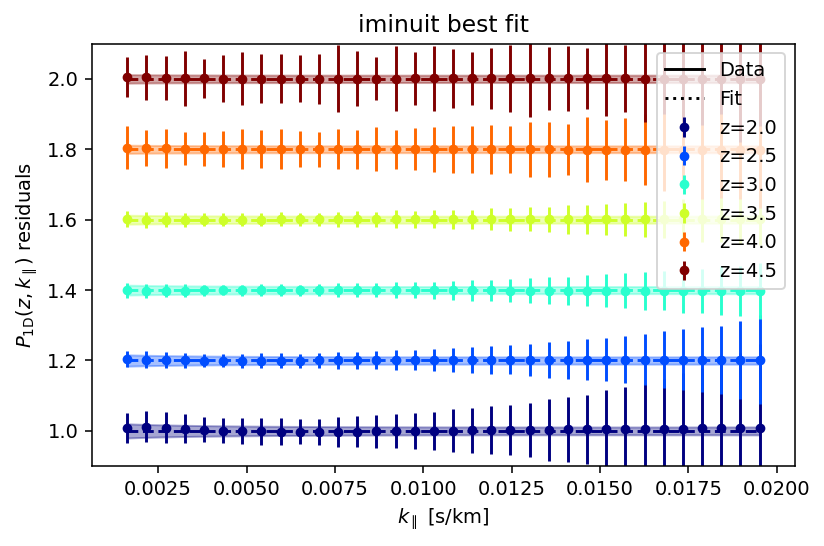

In [17]:
minimizer.plot_best_fit(plot_every_iz=2)

In [18]:
if extra_data:
    like.extra_p1d_like.plot_p1d(values=best_fit_values,residuals=True,plot_every_iz=2)

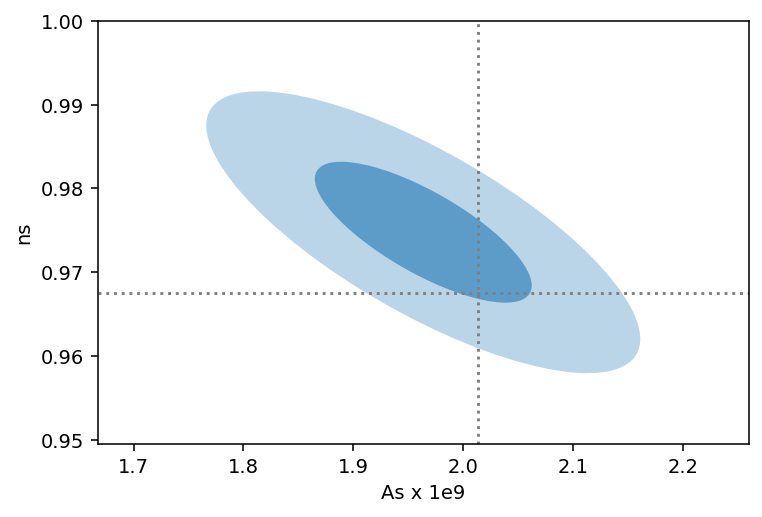

In [19]:
minimizer.plot_ellipses('As','ns')

In [20]:
like.truth

{'ombh2': 0.02199983,
 'omch2': 0.1199999688,
 'As': 2.013797e-09,
 'ns': 0.967556,
 'nrun': 0.0,
 'H0': 74.0,
 'mnu': 0.0,
 'cosmomc_theta': 0.010598132095501974,
 'Delta2_star': 0.3478108522819447,
 'n_star': -2.2981403173359145,
 'alpha_star': -0.21584158790387642,
 'f_star': 0.9757637140725055,
 'g_star': 0.9577005129962274}

### Access the actual minimizer object from iminuit

In [21]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 118.7                      │             Nfcn = 3193              │
│ EDM = 9.48e-05 (Goal: 0.0001)    │           time = 135.1 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.44    │   0.04    │            │            │         │         │       │
│ 1 │ x1   │   0.56    │   0.13    │            │            │         │         │       │
│ 2 │ x2   │   0.522   │   0.022   │            │            │         │         │       │
│ 3 │ x3   │   0.48    │   0.04    │            │            │         │         │       │
│ 4 │ x4   │   0.51    │   0.13    │            │            │         │         │       │
│ 5 │ x5   │   0.35    │   0.20    │            │            │         │         │       │
│ 6 │ x6   │   0.44    │   0.09    │            │            │         │         │       │
│ 7 │ x7   │    0.5    │    0.5    │            │            │         │         │       │
│ 8 │ x8   │    0.4    │    0.4    │            │            │         │         │       │
│ 9 │ x9   │   0.68    │   0.27    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5        x6        x7        x8        x9 │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │   0.00153  -0.00464 -0.000149   0.00126   0.00474   0.00711  -0.00203    0.0188    0.0141    -0.005 │
│ x1 │  -0.00464     0.017 -8.79e-05  -0.00374   -0.0143   -0.0251   0.00678   -0.0654   -0.0456     0.015 │
│ x2 │ -0.000149 -8.79e-05  0.000474 -9.43e-05  9.54e-05 -0.000356  0.000212 -0.000798 -0.000411 -0.000575 │
│ x3 │   0.00126  -0.00374 -9.43e-05   0.00161   0.00483   0.00575  -0.00186    0.0155     0.013  -0.00598 │
│ x4 │   0.00474   -0.0143  9.54e-05   0.00483     0.018    0.0225  -0.00692    0.0611    0.0485   -0.0234 │
│ x5 │   0.00711   -0.0251 -0.000356   0.00575    0.0225    0.0415   -0.0113    0.0995    0.0684   -0.0295 │
│ x6 │  -0.00203   0.00678  0.000212  -0.00186  -0.00692   -0.0113   0.00733   -0.0338   -0.0178   0.00909 │
│ x7 │    0.0188   -0.0654 -0.000798    0.0155    0.0611    0.0995   -0.0338     0.292     0.194   -0.0783 │
│ x8 │    0.0141   -0.0456 -0.000411     0.013    0.0485    0.0684   -0.0178     0.194     0.154   -0.0582 │
│ x9 │    -0.005     0.015 -0.000575  -0.00598   -0.0234   -0.0295   0.00909   -0.0783   -0.0582    0.0727 │
└────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [22]:
#minimizer.minimizer.draw_mncontour("x0", "x1")

In [23]:
#minimizer.minimizer.draw_mnprofile("x0")